In [8]:
!pip install nbformat==5.10.4 nbconvert==7.16.6


In [9]:

import nbformat


# Carga el notebook
notebook_path = "//content/HIGH_DIMENSIONAL_IM (8).ipynb"  # Reemplaza con el nombre correcto
with open(notebook_path, 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

# Limpia solo los metadatos que causan problemas
for cell in nb.cells:
    if 'metadata' in cell and 'widgets' in cell['metadata']:
        del cell['metadata']['widgets']

# Guarda el archivo limpio sin borrar outputs
with open(notebook_path, 'w', encoding='utf-8') as f:
    nbformat.write(nb, f)

# Descarga el archivo limpio con salidas intactas
from google.colab import files
files.download(notebook_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# CLONAR Y PREPARAR TODO
!rm -rf latent-mutual-information
!git clone https://github.com/ggdna/latent-mutual-information.git
%cd /content/latent-mutual-information/lmi

# Renombrar archivo
!mv lmi.py lmi_core.py

# Reparar imports relativos y errores de numpy en todos los archivos relevantes
!sed -i 's/from \. import /import /g' *.py
!sed -i 's/np\.NaN/np.nan/g' *.py

# Añadir ruta al sistema
import sys
sys.path.append('/content/latent-mutual-information/lmi')

# IMPORTAR MÓDULOS
import lmi_core as lmi
import models
import ksg

# DATASET Y EJECUCIÓN
import numpy as np
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data

X1 = X[:, :15]
X2 = X[:, 15:]

estimate, (Zx, Zy), model = lmi.lmi(X1, X2,
                                    regularizer='models.AECross',
                                    alpha=1, lam=1,
                                    N_dims=8, epochs=50, quiet=False)

estimate

Cloning into 'latent-mutual-information'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 243 (delta 104), reused 178 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (243/243), 21.93 MiB | 6.49 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Updating files: 100% (70/70), done.
/content/latent-mutual-information/lmi


  0%|          | 0/50 [00:00<?, ?Epoch/s]

array([        nan,         nan,         nan,  3.04371063,         nan,
               nan,  4.40275751,         nan,         nan,         nan,
        2.37991153,  0.1249205 ,         nan,         nan,         nan,
        4.02280639,  0.86185874,  3.30699628,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,  3.55549646,  2.37672301,  2.16691534,  4.14737135,
               nan,  3.7169409 ,  1.76704864,         nan,  3.62677246,
               nan,  3.31369225,  0.22531636,  0.39782   ,  2.99886948,
        0.3002742 ,         nan,         nan,         nan,         nan,
        2.57209638,  2.47774947,         nan,         nan,  1.00637748,
        1.12846203,         nan,  1.64482406,         nan,         nan,
               nan,  2.92345863,         nan,         nan,  1.742662  ,
        1.33565128,  0.96687844,         nan,         nan,         nan,
        0.37418664,  0.88910281,         nan,  0.07279998,  1.06

  0%|          | 0/50 [00:00<?, ?Epoch/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


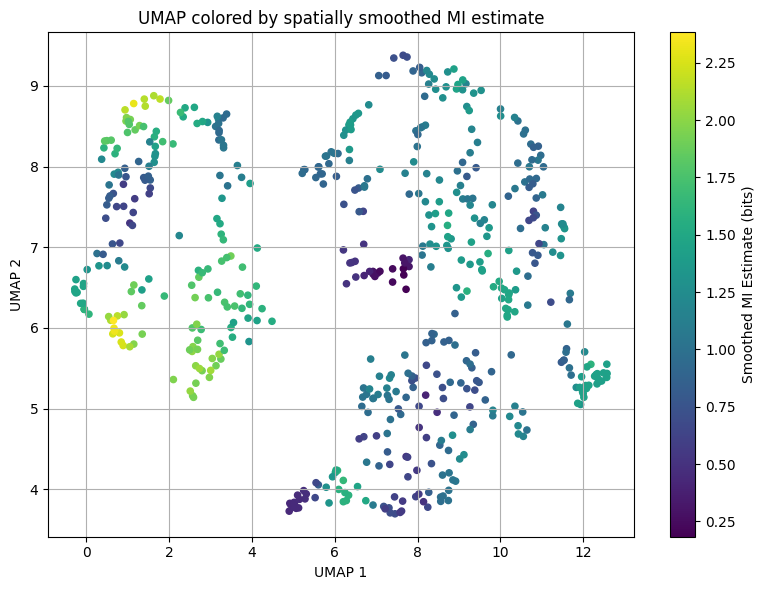

In [ ]:

import lmi_core as lmi
import models
import ksg

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Datos
data = load_breast_cancer()
X = StandardScaler().fit_transform(data.data)
y = data.target

X1 = X[:, :15]
X2 = X[:, 15:]

# LMI
estimate, (Zx, Zy), model = lmi.lmi(X1, X2,
                                    regularizer='models.AECross',
                                    alpha=1, lam=1,
                                    N_dims=8, epochs=50, quiet=False)

estimate = np.nan_to_num(estimate)
estimate = np.maximum(estimate, 0)

# --- UMAP ---
Z_concat = np.concatenate([Zx, Zy], axis=1)
reducer = umap.UMAP(n_components=2, random_state=42)
Z_umap = reducer.fit_transform(Z_concat)

# --- SMOOTHING SOBRE EL MANIFOLD UMAP ---
def spatial_smoothing(values, coords, n_neighbors=15, sigma=1.0):
    knn = NearestNeighbors(n_neighbors=n_neighbors).fit(coords)
    indices = knn.kneighbors(coords, return_distance=False)
    smoothed = np.zeros_like(values)

    for i, neighbors in enumerate(indices):
        dists = np.linalg.norm(coords[neighbors] - coords[i], axis=1)
        weights = np.exp(-dists**2 / (2 * sigma**2))
        weights /= weights.sum()
        smoothed[i] = np.sum(weights * values[neighbors])
    return smoothed

estimate_smooth = spatial_smoothing(estimate, Z_umap, n_neighbors=20, sigma=1.0)

# --- VISUALIZACIÓN ---
plt.figure(figsize=(8, 6))
sc = plt.scatter(Z_umap[:, 0], Z_umap[:, 1], c=estimate_smooth, cmap='viridis', s=20)
plt.title("UMAP colored by spatially smoothed MI estimate")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.colorbar(sc, label="Smoothed MI Estimate (bits)")
plt.tight_layout()
plt.show()



In [ ]:
X.shape

In [ ]:
# INSTALAR DEPENDENCIAS
!pip install umap-learn matplotlib --quiet

# IMPORTAR MÓDULOS
import lmi_core as lmi
import models
import ksg

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# CARGAR Y NORMALIZAR DATOS
data = load_breast_cancer()
X = data.data
y = data.target  # clases: 0 = maligno, 1 = benigno
X = StandardScaler().fit_transform(X)

# SEPARAR EN DOS VISTAS
X1 = X[:, :15]
X2 = X[:, 15:]

# CALCULAR LMI
estimate, (Zx, Zy), model = lmi.lmi(X1, X2,
                                    #regularizer='models.AECross',
                                    #alpha=1, lam=1,
                                    N_dims=8, epochs=500, quiet=False)

# PROYECTAR X CON UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# VISUALIZACIÓN
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# MI ESTIMADA
sc1 = axs[0].scatter(X_umap[:, 0], X_umap[:, 1], c=estimate, cmap='viridis', s=20)
axs[0].set_title("UMAP colored by Estimated MI")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].grid(True)
plt.colorbar(sc1, ax=axs[0], label="LMI")

# CLASES VERDADERAS
sc2 = axs[1].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='coolwarm', s=20)
axs[1].set_title("UMAP colored by True Labels")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].grid(True)
plt.colorbar(sc2, ax=axs[1], label="Class (0 = Malignant, 1 = Benign)")

plt.tight_layout()
plt.show()


Z_concat = np.concatenate([Zx, Zy], axis=1)
# PROYECTAR Zx CON UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
Zx_umap = reducer.fit_transform(Z_concat)

# VISUALIZACIÓN
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ESTIMATE
sc1 = axs[0].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=estimate, cmap='viridis', s=20)
axs[0].set_title("UMAP of Zx colored by MI Estimate")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].grid(True)
plt.colorbar(sc1, ax=axs[0], label="MI Estimate (bits)")

# ETIQUETAS REALES
sc2 = axs[1].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=y, cmap='coolwarm', s=20)
axs[1].set_title("UMAP of Zx colored by Class")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].grid(True)
plt.colorbar(sc2, ax=axs[1], label="Class (0=Malignant, 1=Benign)")

plt.tight_layout()
plt.show()


In [ ]:
!pip install  scanpy --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.7 MB/s eta 0:00:00


  0%|          | 0.00/3.24M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


  0%|          | 0/500 [00:00<?, ?Epoch/s]

Training stopped at epoch  383
Validation loss: 1.3853012323379517


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


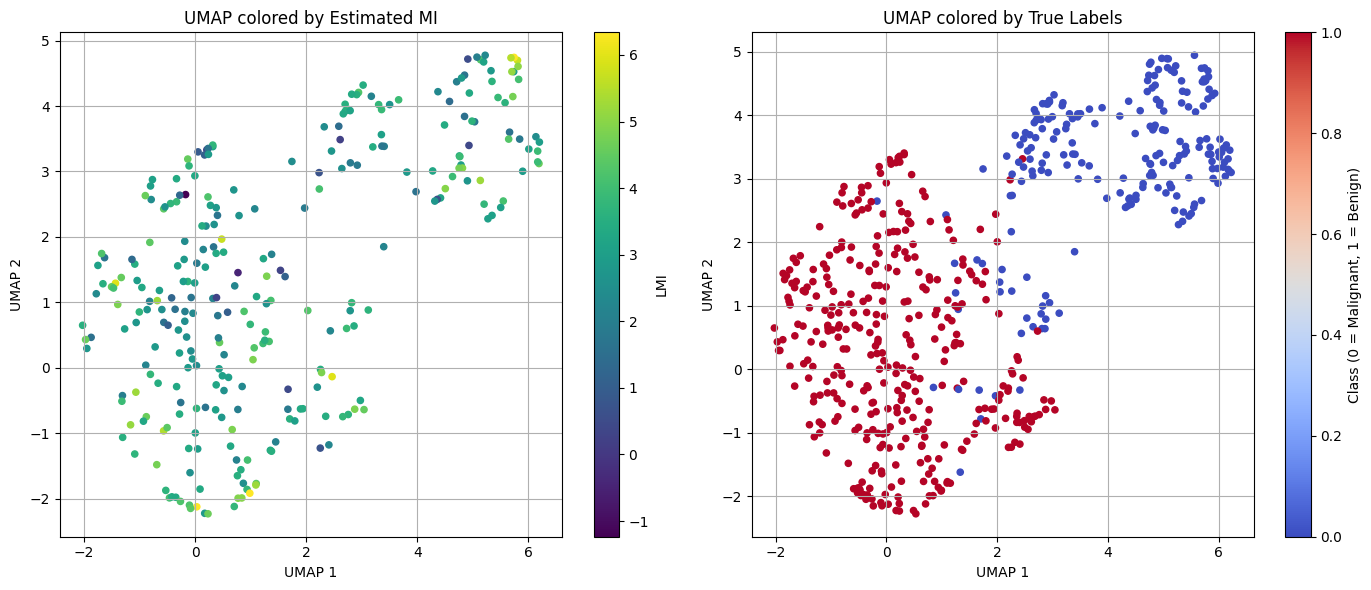

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


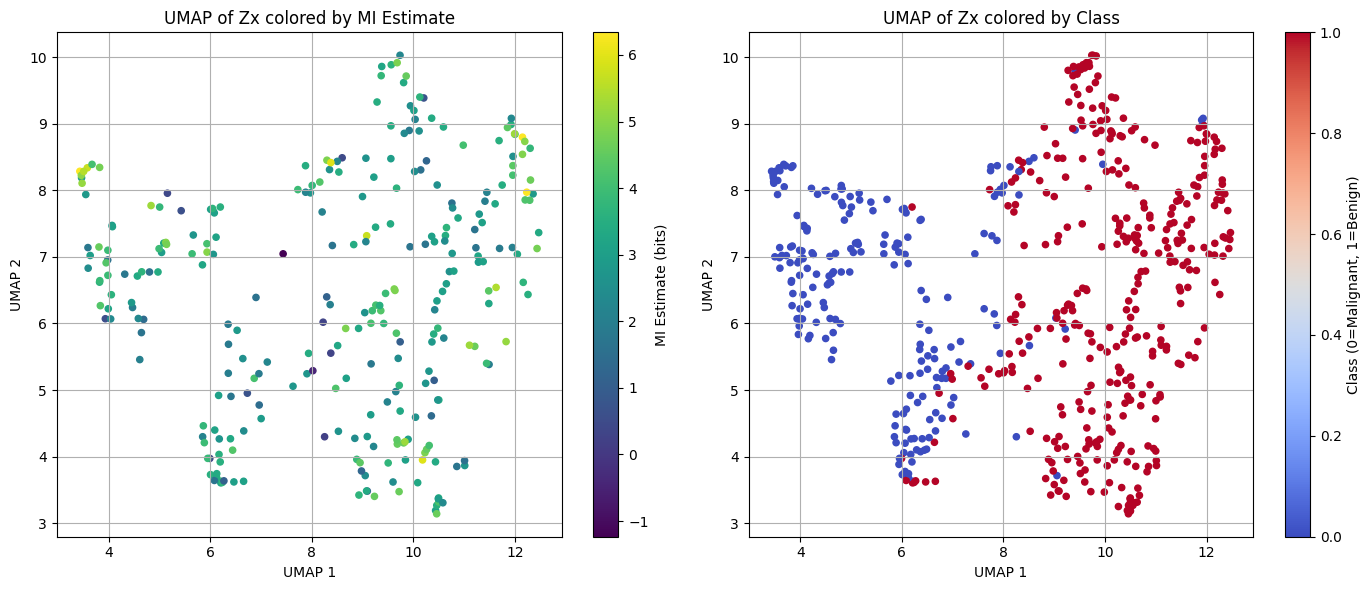

In [ ]:
import scanpy as sc
adata = sc.datasets.moignard15()
adata



    # IMPORTAR MÓDULOS
import lmi_core as lmi
import models
import ksg

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# CARGAR Y NORMALIZAR DATOS
data = load_breast_cancer()
X = data.data
y = data.target  # clases: 0 = maligno, 1 = benigno
X = StandardScaler().fit_transform(X)

# SEPARAR EN DOS VISTAS
X1 = X[:, :15]
X2 = X[:, 15:]

# CALCULAR LMI
estimate, (Zx, Zy), model = lmi.lmi(X1, X2,
                                    #regularizer='models.AECross',
                                    #alpha=1, lam=1,
                                    N_dims=8, epochs=500, quiet=False)

# PROYECTAR X CON UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# VISUALIZACIÓN
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# MI ESTIMADA
sc1 = axs[0].scatter(X_umap[:, 0], X_umap[:, 1], c=estimate, cmap='viridis', s=20)
axs[0].set_title("UMAP colored by Estimated MI")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].grid(True)
plt.colorbar(sc1, ax=axs[0], label="LMI")

# CLASES VERDADERAS
sc2 = axs[1].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='coolwarm', s=20)
axs[1].set_title("UMAP colored by True Labels")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].grid(True)
plt.colorbar(sc2, ax=axs[1], label="Class (0 = Malignant, 1 = Benign)")

plt.tight_layout()
plt.show()


Z_concat = np.concatenate([Zx, Zy], axis=1)
# PROYECTAR Zx CON UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
Zx_umap = reducer.fit_transform(Z_concat)

# VISUALIZACIÓN
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ESTIMATE
sc1 = axs[0].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=estimate, cmap='viridis', s=20)
axs[0].set_title("UMAP of Zx colored by MI Estimate")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].grid(True)
plt.colorbar(sc1, ax=axs[0], label="MI Estimate (bits)")

# ETIQUETAS REALES
sc2 = axs[1].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=y, cmap='coolwarm', s=20)
axs[1].set_title("UMAP of Zx colored by Class")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].grid(True)
plt.colorbar(sc2, ax=axs[1], label="Class (0=Malignant, 1=Benign)")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


  0%|          | 0/100 [00:00<?, ?Epoch/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


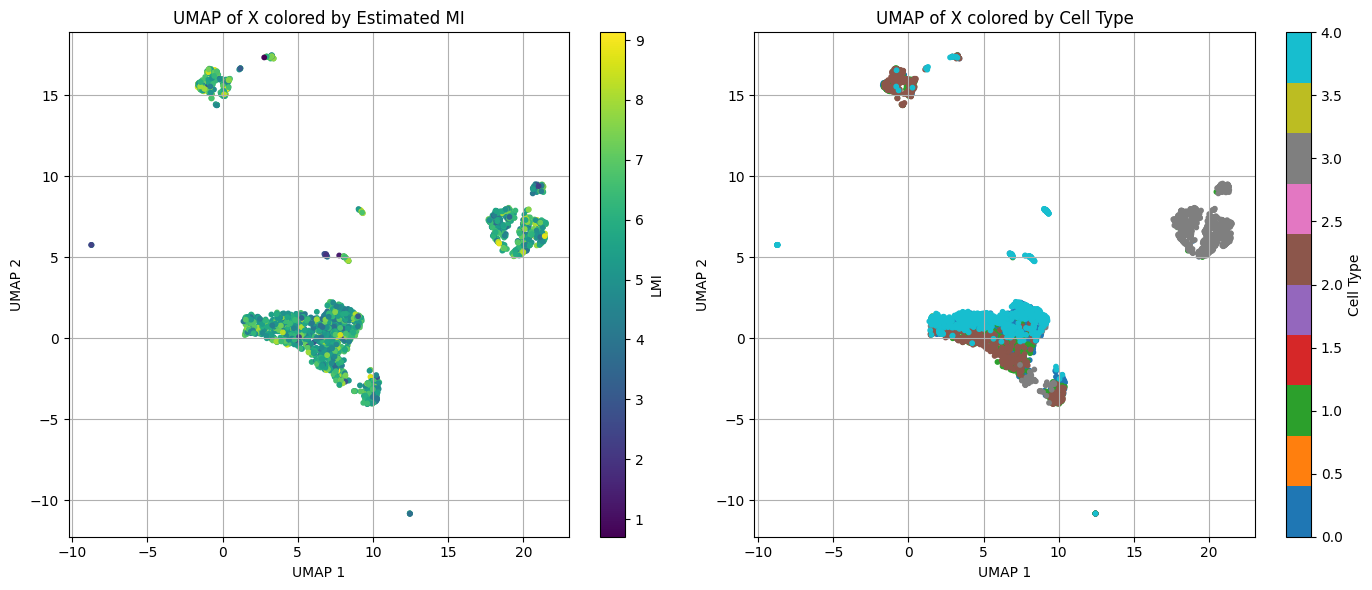

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


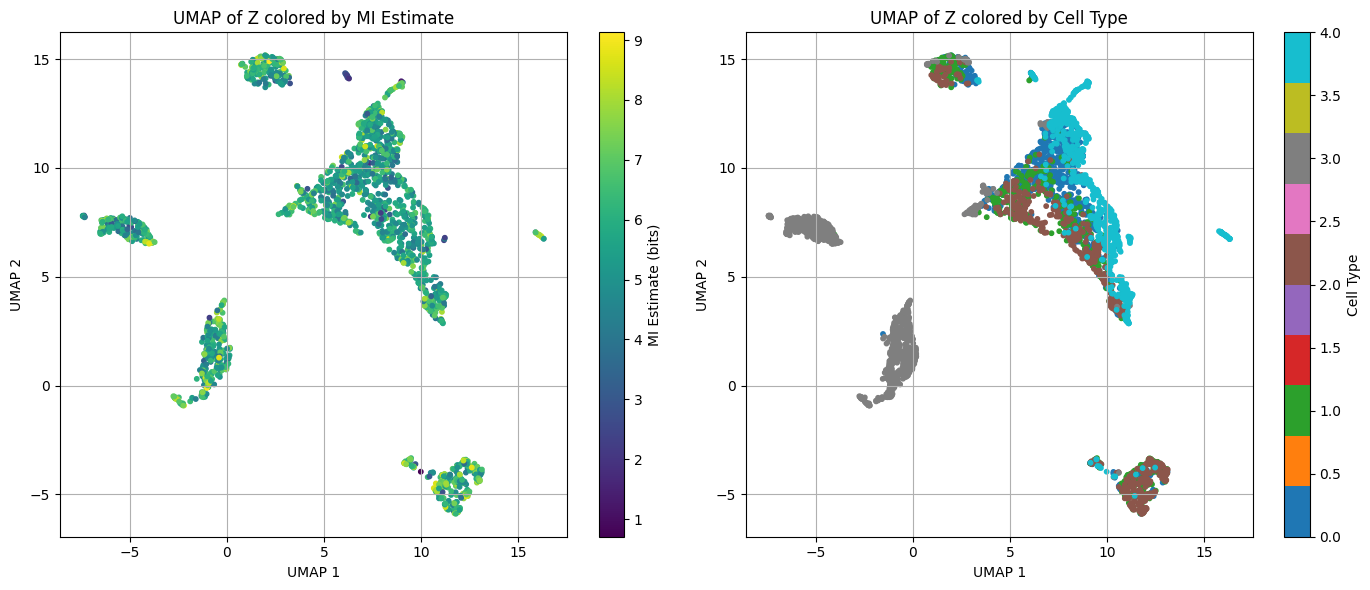

In [ ]:
# INSTALAR DEPENDENCIAS

# IMPORTAR MÓDULOS
import scanpy as sc
import lmi_core as lmi
import models
import ksg

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

# CARGAR DATOS DE DIFERENCIACIÓN CELULAR
adata = sc.datasets.moignard15()
X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
y = adata.obs["exp_groups"].astype("category").cat.codes.values  # codificar clases como enteros
X = StandardScaler().fit_transform(X)

# SEPARAR EN DOS VISTAS
X1 = X[:, :]
X2 = X[:, :]

# CALCULAR LMI
estimate, (Zx, Zy), model = lmi.lmi(X1, X2,
                                    regularizer='models.AECross',
                                    alpha=1, lam=1,
                                    N_dims=8, epochs=100, quiet=False)

# PROYECTAR X CON UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# VISUALIZACIÓN ORIGINAL
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sc1 = axs[0].scatter(X_umap[:, 0], X_umap[:, 1], c=estimate, cmap='viridis', s=10)
axs[0].set_title("UMAP of X colored by Estimated MI")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].grid(True)
plt.colorbar(sc1, ax=axs[0], label="LMI")

sc2 = axs[1].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='tab10', s=10)
axs[1].set_title("UMAP of X colored by Cell Type")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].grid(True)
plt.colorbar(sc2, ax=axs[1], label="Cell Type")

plt.tight_layout()
plt.show()

# CONCATENAR Zx y Zy
Z_concat = np.concatenate([Zx, Zy], axis=1)

# UMAP EN Z
Zx_umap = reducer.fit_transform(Z_concat)

# VISUALIZACIÓN EMBEBIDA
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sc1 = axs[0].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=estimate, cmap='viridis', s=10)
axs[0].set_title("UMAP of Z colored by MI Estimate")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].grid(True)
plt.colorbar(sc1, ax=axs[0], label="MI Estimate (bits)")

sc2 = axs[1].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=y, cmap='tab10', s=10)
axs[1].set_title("UMAP of Z colored by Cell Type")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].grid(True)
plt.colorbar(sc2, ax=axs[1], label="Cell Type")

plt.tight_layout()
plt.show()


In [ ]:
adata.obsm['X_umap']

array([[ 1.35285574,  2.26612719],
       [-0.47802448,  7.87730423],
       [ 2.16588875, -0.24481226],
       ...,
       [ 0.34670979,  8.34967798],
       [ 0.19864146,  9.56698797],
       [ 2.62803322,  0.36722543]])

  0%|          | 0/1000 [00:00<?, ?Epoch/s]

Training stopped at epoch  139
Validation loss: 3.4981395403544107


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


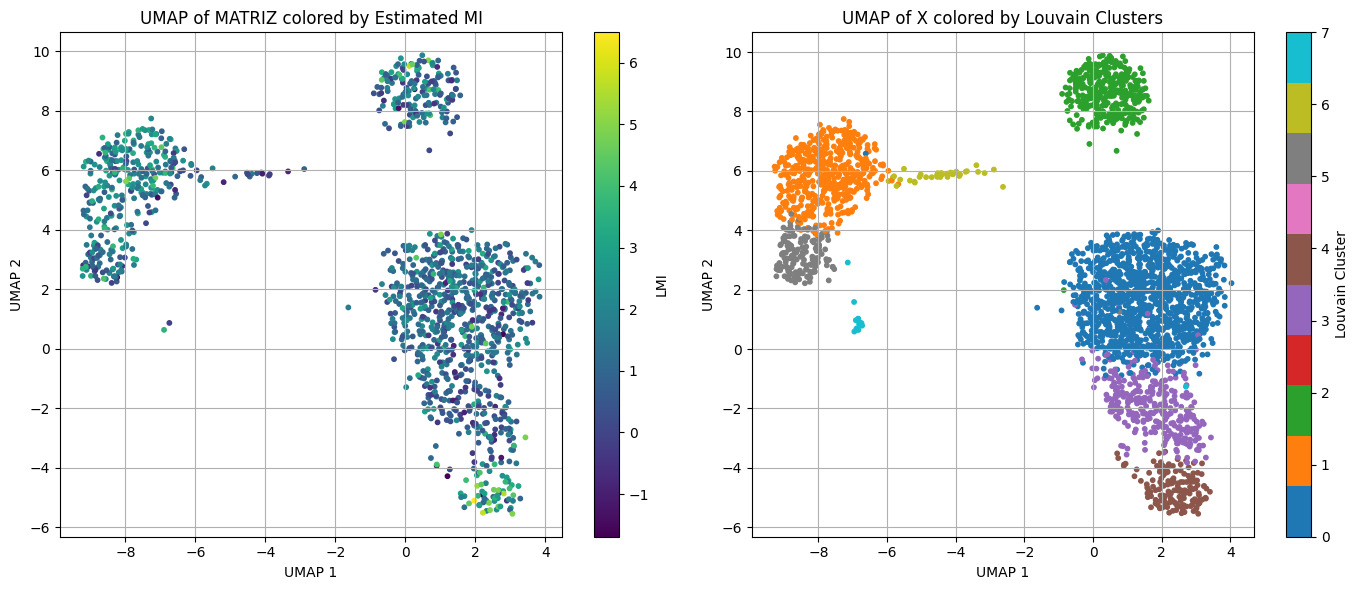

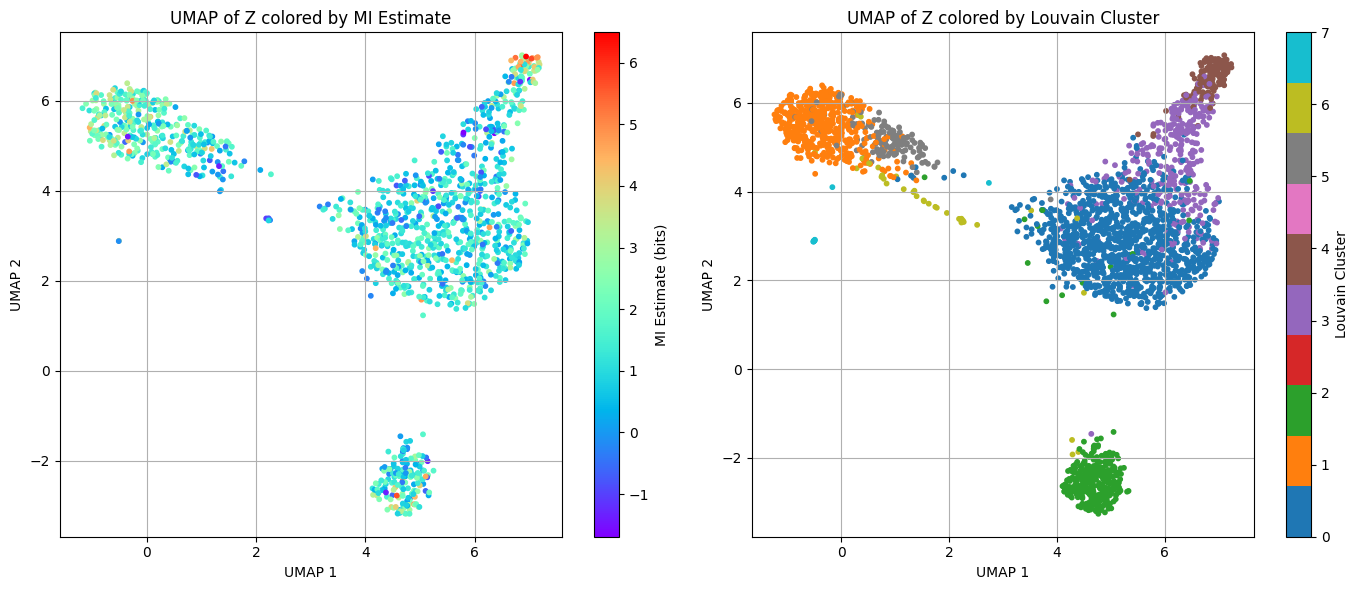

In [ ]:
import scanpy as sc
import lmi_core as lmi
import models
import ksg

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

# CARGAR Y NORMALIZAR DATOS
adata = sc.datasets.pbmc3k_processed()
X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
y = adata.obs["louvain"].astype("category").cat.codes.values
#X = StandardScaler().fit_transform(X)


# SEPARAR EN DOS VISTAS
X1 = X
X2 = X

# CALCULAR LMI
estimate, (Zx, Zy), model = lmi.lmi(X1, X2,
                                    regularizer='models.AECross',
                                    alpha=1, lam=1,
                                    N_dims=100, epochs=1000, quiet=False)



# CONCATENAR Zx y Zy
Z_concat = np.concatenate([Zx, Zy], axis=1)

# UMAP EN Z
Zx_umap = reducer.fit_transform(Z_concat)

# VISUALIZACIÓN ORIGINAL
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sc1 = axs[0].scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], c=estimate, cmap='viridis', s=10)
axs[0].set_title("UMAP of MATRIZ colored by Estimated MI")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].grid(True)
plt.colorbar(sc1, ax=axs[0], label="LMI")

sc2 = axs[1].scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], c=y, cmap='tab10', s=10)
axs[1].set_title("UMAP of X colored by Louvain Clusters")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].grid(True)
plt.colorbar(sc2, ax=axs[1], label="Louvain Cluster")

plt.tight_layout()
plt.show()



# VISUALIZACIÓN EMBEBIDA
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sc1 = axs[0].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=estimate, cmap='rainbow', s=10)
axs[0].set_title("UMAP of Z colored by MI Estimate")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].grid(True)
plt.colorbar(sc1, ax=axs[0], label="MI Estimate (bits)")

sc2 = axs[1].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=y, cmap='tab10', s=10)
axs[1].set_title("UMAP of Z colored by Louvain Cluster")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].grid(True)
plt.colorbar(sc2, ax=axs[1], label="Louvain Cluster")

plt.tight_layout()
plt.show()


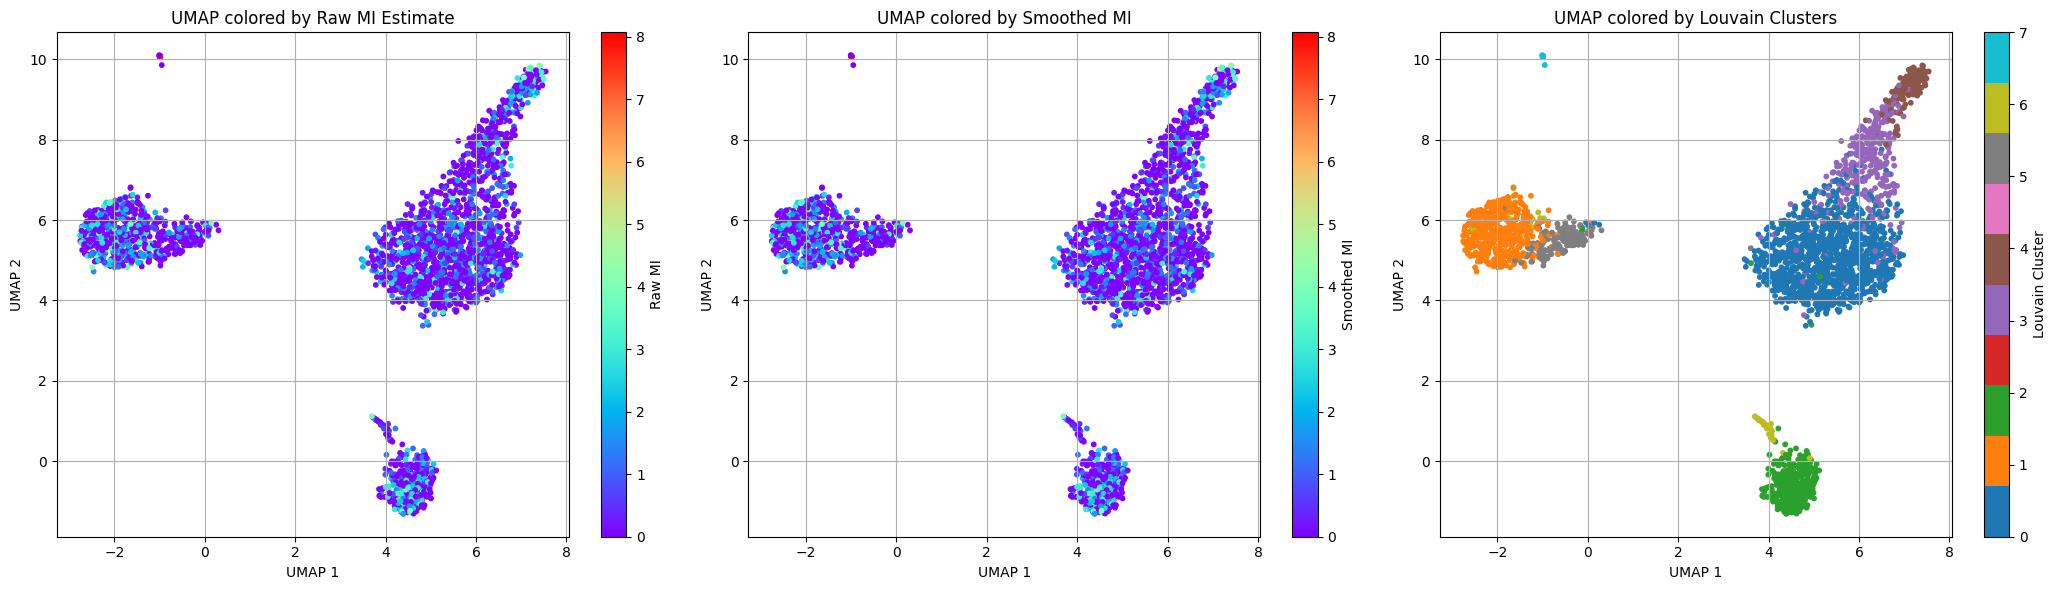

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Asegurar que no haya NaNs y que todo sea >= 0
estimate_clean = np.nan_to_num(estimate, nan=0.0)
estimate_clean = np.clip(estimate_clean, a_min=0, a_max=None)

# Suavizado espacial en el manifold
knn = KNeighborsRegressor(n_neighbors=20, weights='distance')
smoothed_estimate = knn.fit(Zx_umap, estimate_clean).predict(Zx_umap)

# VISUALIZACIÓN TRIPANEL
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

# MI ESTIMADA (cruda)
sc1 = axs[0].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=estimate_clean, cmap='rainbow', s=10)
axs[0].set_title("UMAP colored by Raw MI Estimate")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].grid(True)
plt.colorbar(sc1, ax=axs[0], label="Raw MI")

# MI SUAVIZADA
sc2 = axs[1].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=smoothed_estimate, cmap='rainbow', s=10)
axs[1].set_title("UMAP colored by Smoothed MI")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].grid(True)
plt.colorbar(sc2, ax=axs[1], label="Smoothed MI")

# CLUSTERS
sc3 = axs[2].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=y, cmap='tab10', s=10)
axs[2].set_title("UMAP colored by Louvain Clusters")
axs[2].set_xlabel("UMAP 1")
axs[2].set_ylabel("UMAP 2")
axs[2].grid(True)
plt.colorbar(sc3, ax=axs[2], label="Louvain Cluster")

plt.tight_layout()
plt.show()



  0%|          | 0/2000 [00:00<?, ?Epoch/s]

Training stopped at epoch  129
Validation loss: 3.51315975189209


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


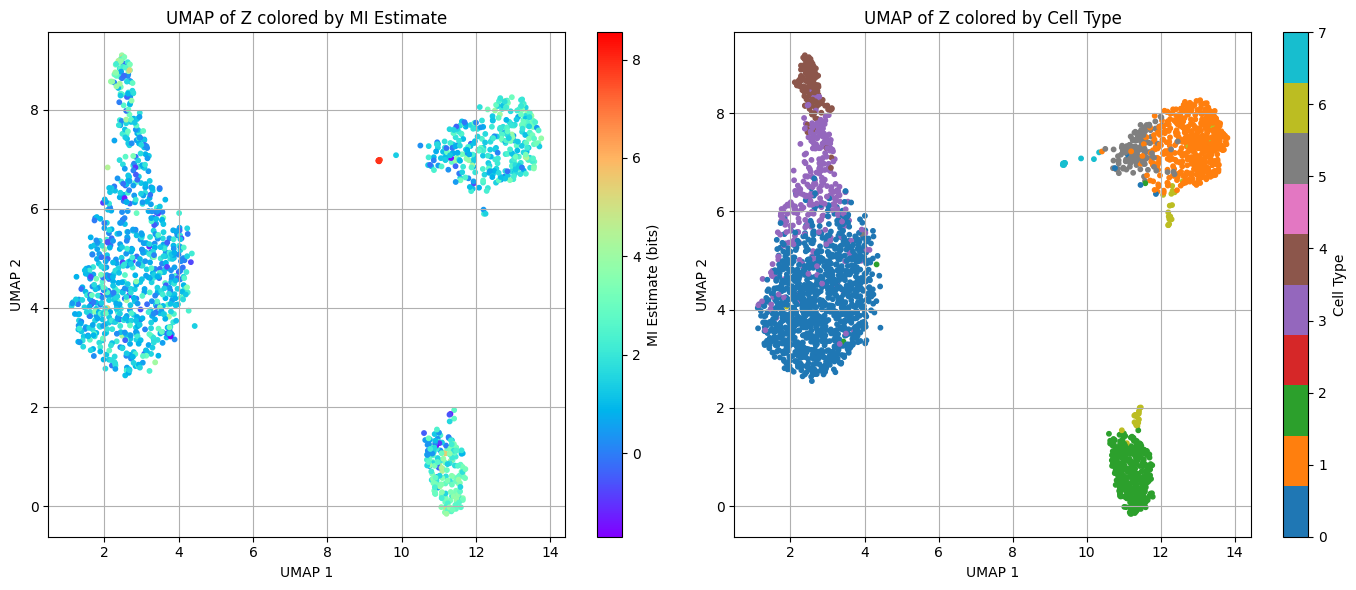

In [ ]:
# SEPARAR EN DOS VISTAS
X1 = X
X2 = X

# CALCULAR LMI
estimate, (Zx, Zy), model = lmi.lmi(X1, X2,
                                    regularizer='models.AECross',
                                    alpha=1, lam=1,
                                    N_dims=50, epochs=2000, quiet=False)

# CONCATENAR Zx y Zy
Z_concat = np.concatenate([Zx, Zy], axis=1)

# UMAP EN Z
Zx_umap = reducer.fit_transform(Z_concat)

# VISUALIZACIÓN EMBEBIDA
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sc1 = axs[0].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=estimate, cmap='rainbow', s=10)
axs[0].set_title("UMAP of Z colored by MI Estimate")
axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].grid(True)
plt.colorbar(sc1, ax=axs[0], label="MI Estimate (bits)")

sc2 = axs[1].scatter(Zx_umap[:, 0], Zx_umap[:, 1], c=y, cmap='tab10', s=10)
axs[1].set_title("UMAP of Z colored by Cell Type")
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].grid(True)
plt.colorbar(sc2, ax=axs[1], label="Cell Type")

plt.tight_layout()
plt.show()

In [ ]:
X

array([], shape=(0, 1838), dtype=float32)